In [1]:
import sys; sys.path.append('..')
from adjective_reading.parsing import *
import networkx as nx


OK


In [2]:
df = pd.read_csv('../data/keyword_sent_corpus_parsed.csv.gz').fillna('')
df = df.query('1920 <= year <= 2020')
df['head_text_lower'] = df['head_text'].str.lower()
df['text_lower'] = df['text'].str.lower()
df['phrase_lower'] = df['phrase'].str.lower()
df =df.drop_duplicates(subset=['url','context1'])
df.iloc[0]

url                               http://www.jstor.org/stable/461288
page_num                                                           4
sent_num                                                           4
sent               We are all our lifetime __reading__ the copiou...
context0           194 Pascal et le d6s6quilibre ment cette circu...
context1           We are all our lifetime reading the copious se...
context2           One moral we have already deduced, in consider...
token_num                                                          5
token0                                                      lifetime
token1                                                       reading
token2                                                           the
lemma                                                           read
pos                                                             VERB
year                                                            1967
decade                            

In [3]:
decade2phrases = {
    decade: str(decade_df.phrase.value_counts().head(25))
    for decade, decade_df in df.groupby('decade')
}
print(decade2phrases[1920])

phrase
the reading                       143
his reading                        37
The reading                        34
the reading public                 32
a reading                          24
the original reading               17
this reading                       13
their reading                      12
the correct reading                 8
wide reading                        8
the general reading public          7
This reading                        7
such reading                        5
worth reading                       5
The reading and discussion          5
the MS. reading                     5
the actual reading                  5
His reading                         5
the right reading                   5
my reading                          5
proof - reading                     4
the manuscript reading              4
his wide reading                    4
better reading                      4
the generally accepted reading      4
Name: count, dtype: int64


In [4]:
df

,url,page_num,sent_num,sent,context0,context1,context2,token_num,token0,token1,...,head_idx,head_text,head_pos,head_lemma,idx,prep,cc,head_text_lower,text_lower,phrase_lower
0,http://www.jstor.org/stable/461288,4,4,We are all our lifetime __reading__ the copiou...,194 Pascal et le d6s6quilibre ment cette circu...,We are all our lifetime reading the copious se...,"One moral we have already deduced, in consider...",5,lifetime,reading,...,5,lifetime,NOUN,lifetime,6,,,lifetime,reading,are all our lifetime reading the copious sense...
2,http://www.jstor.org/stable/459148,1,6,It is this conflict that is responsible for th...,"""4 Had Shelley composed the poem in tranquilit...",It is this conflict that is responsible for th...,"The real difficulty in reading ""Mont Blanc"" is...",22,cult,reading,...,22,such,ADJ,such,25,,,such,reading,such diffi- cult reading
7,http://www.jstor.org/stable/459148,1,7,"The real difficulty in __reading__ ""Mont Blanc...","""4 Had Shelley composed the poem in tranquilit...","The real difficulty in reading ""Mont Blanc"" is...","The particular subject matters of ""Mont Blanc""...",4,in,reading,...,4,in,SCONJ,in,5,,,in,reading,"in reading "" mont blanc """
10,http://www.jstor.org/stable/459148,2,2,The poet's ambiguous attitude towards his subj...,I. J. Kapstein last three lines; here with a s...,The poet's ambiguous attitude towards his subj...,,13,in,reading,...,14,in,SCONJ,in,15,,,in,reading,"in reading the first eleven lines, comprising,..."
14,http://www.jstor.org/stable/459148,5,10,"By this __reading__, therefore, Shelley is say...","But if ""passively"" is taken as qualifying ""now...","By this reading, therefore, Shelley is saying ...",The idea of the passivity of mind in knowledge...,2,this,reading,...,2,this,DET,this,3,,,this,reading,this reading
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117450,http://www.jstor.org/stable/3725629,3,18,But surely the impression received from a __re...,There is a reference to the heat of the day at...,But surely the impression received from a read...,"Bedier claims (Le Roman de Tristan par Thomas,...",7,a,reading,...,7,a,DET,a,8,,,a,reading,a reading
117453,http://www.jstor.org/stable/468924,8,13,"It would be easy to argue, in the literary fie...",III.\nSocial Engineering and the Migrations of...,"It would be easy to argue, in the literary fie...","all register, in one way or the other, a decli...",33,strong,reading,...,45,weak,ADJ,weak,46,,,weak,reading,weak reading
117459,http://www.jstor.org/stable/468924,8,15,"This would be correct, however, only if decons...","Between these two, a polarity if not an actual...","This would be correct, however, only if decons...",That is not so.\nIt requires the individualize...,10,strong,reading,...,21,the,DET,the,24,,,the,reading,the common man reading
117477,http://www.jstor.org/stable/468924,9,10,"Then the critic's, or reader's, individuality ...",The writer is now producing not a criticism of...,"Then the critic's, or reader's, individuality ...","What is at issue in this, though, is less the ...",12,strong,reading,...,16,"""",PUNCT,"""",18,,,"""",reading,"the "" strong reading "" process"


In [5]:
df['context1_highlighted'] = df.apply(
    lambda row: re.sub(
        re.escape(row['phrase_lower']), 
        '***'+row['phrase_lower'].upper()+'***', 
        row['context1'], 
        flags=re.IGNORECASE
    ), 
    axis=1
)

In [6]:
# df['context1_highlighted']
df.groupby('decade').size()

decade
1920    1441
1930    2036
1940    1903
1950    2893
1960    3673
1970    3695
1980    3575
1990    3462
2000    3451
2010    3527
dtype: int64

In [7]:
def get_period_counts(df, by=['decade', 'head_pos', 'head_text_lower', 'relation','pos', 'text_lower','phrase_lower'], period_col='decade', period_size=1000):
    period_counts = df.groupby(period_col).size().reset_index(name='period_count')
    min_period_size = period_counts['period_count'].min()

    # df2 = df.groupby(period_col).sample(min_period_size)
    df2 = df

    # Group by the specified columns and aggregate
    grouped = df2.groupby(by)
    
    # Count occurrences
    df_counts = grouped.size().reset_index(name='count')
    
    # Collect example sentences (one per line)
    examples = grouped['context1_highlighted'].apply(lambda x: '\n'.join(x.unique())[:1000]).reset_index(name='examples')
    
    # Merge counts with period counts
    odf = pd.merge(df_counts, period_counts, on=period_col)
    
    # Add examples column
    odf = pd.merge(odf, examples, on=by)
    
    odf['fpk'] = odf['count'] / odf['period_count'] * 1000
    return odf

In [8]:
ok_pos = ['ADJ', 'NOUN']
odf = get_period_counts(df.query('head_pos in @ok_pos')).sort_values('fpk', ascending=False)#.query('head_pos in @ok_pos').head(25)
odf.groupby('decade')['count'].sum()

decade
1920     326
1930     484
1940     469
1950     746
1960    1048
1970    1080
1980    1036
1990    1002
2000    1098
2010    1219
Name: count, dtype: int64

In [9]:
print(odf.iloc[0].examples)

But, meantime, the actual growth of ***THE READING PUBLIC*** suffered a check.
It meant that the small section of ***THE READING PUBLIC*** which it is convenient to call the literary public, had sufficiently increased to be able to support a magazine devoted to literature and science.
The novel, too, played a prominent part in developing ***THE READING PUBLIC***.
* Most important from the position of the literary calling was the enormous extension in ***THE READING PUBLIC*** which was the natural result.
In the two poems that have al- ready rendered his name well known to ***THE READING PUBLIC***, the same lament- able perverseness of thought and belief was sufficiently visible."
He would hardly have spoken of 'our unhappie booke' if he had been referring to performances (in spite of the technical application of the term) and if 'presented' does suggest performance, his subsequent phrase 'our play so much importun'de' points unequivocally to the demand of ***THE READING PUBLIC***.
But 

In [10]:
# !pip install openpyxl
odf[odf['count']>1].to_excel('../data/keyword_rel_counts.xlsx',index=False)


In [11]:
odf2 = odf.groupby('decade').agg({'count': 'sum', 'period_count': 'mean'})
odf2['fpk'] = odf2['count'] / odf2['period_count'] * 1000
odf2


,count,period_count,fpk
decade,,,
1920,326,326.0,1000.0
1930,484,484.0,1000.0
1940,469,469.0,1000.0
1950,746,746.0,1000.0
1960,1048,1048.0,1000.0
1970,1080,1080.0,1000.0
1980,1036,1036.0,1000.0
1990,1002,1002.0,1000.0
2000,1098,1098.0,1000.0


In [12]:
ok_pos = ['ADJ', 'NOUN']
top_phrases = odf.query('head_pos in @ok_pos & count > 0').groupby('phrase_lower')['fpk'].sum().sort_values(ascending=False)
top_phrases

phrase_lower
the reading public                                                                                                                                                                                                                                               372.564943
close reading                                                                                                                                                                                                                                                    232.824626
proof - reading                                                                                                                                                                                                                                                  146.675867
wide reading                                                                                                                                                                           

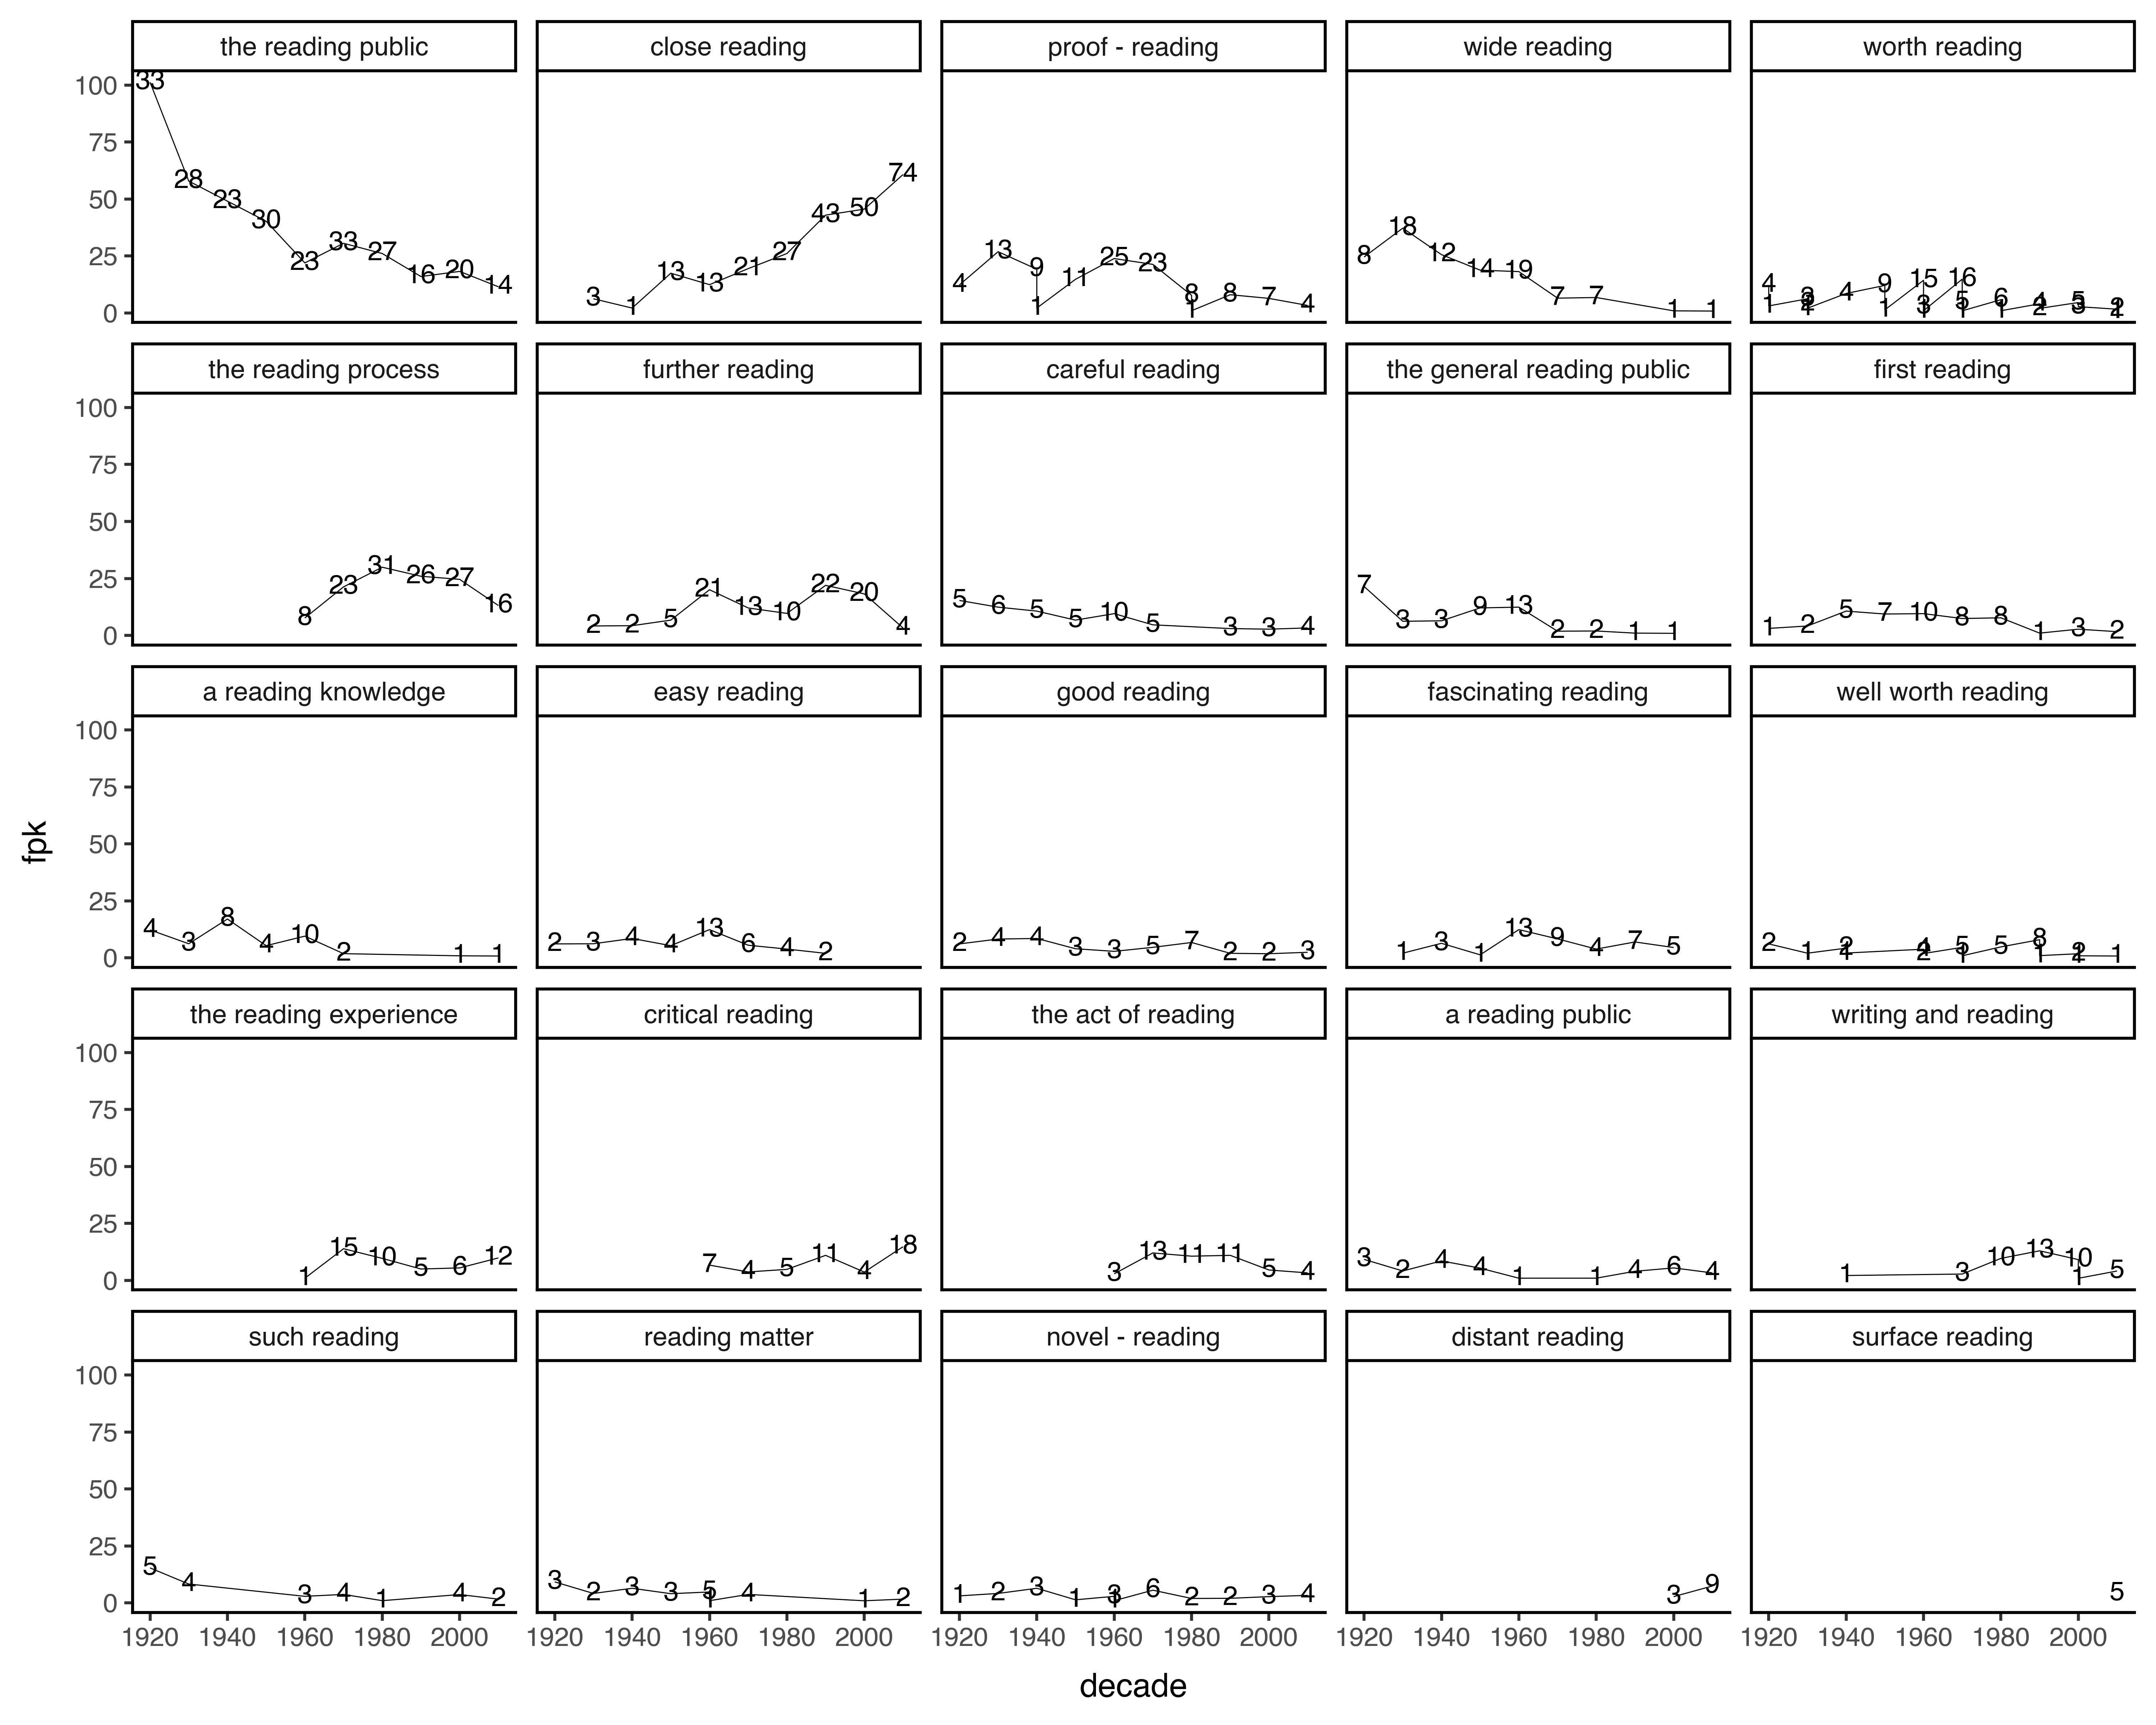

In [13]:
p9.options.figure_size = (10, 8)
p9.options.dpi = 300

top_phrases_l = list(top_phrases.index[:23])
force_phrases = ['distant reading', 'surface reading']
for fphr in force_phrases:
    if not fphr in top_phrases_l:
        top_phrases_l.append(fphr)
top_phrases_l.sort(key=lambda x: top_phrases[x], reverse=True)



figdf = odf.query('phrase_lower in @top_phrases_l').copy()
figdf['facet'] = pd.Categorical(figdf['phrase_lower'], categories=top_phrases_l, ordered=True)
figdf['fpk_label'] = figdf['fpk'].round(1)
fig = p9.ggplot(figdf, p9.aes(x='decade', y='fpk'))
fig += p9.geom_line(size=.2)
# fig += p9.geom_point()
fig += p9.geom_text(p9.aes(label='count'), size=9)
fig += p9.facet_wrap('~facet')
fig += p9.theme_classic()
fig

In [14]:
# !pip install seaborn

In [26]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# import matplotlib.patches as patches

# def create_hover_seaborn_graph(df, top_phrases_list, ncols=4):
#     """
#     Create a seaborn graph with matplotlib-based hover functionality
    
#     Parameters:
#     df: DataFrame with columns ['decade', 'fpk', 'count', 'phrase_lower', 'examples']
#     top_phrases_list: List of phrases to include (ordered by importance)
#     ncols: Number of columns in the facet grid
#     """
    
#     # Set up the plotting style
#     sns.set_style("whitegrid", {'grid.color': '.95', 'grid.linestyle': ':'})
#     plt.rcParams['font.family'] = 'sans-serif'
#     plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    
#     # Filter and prepare data
#     figdf = df[df['phrase_lower'].isin(top_phrases_list)].copy()
#     figdf['phrase_lower'] = pd.Categorical(
#         figdf['phrase_lower'], 
#         categories=top_phrases_list, 
#         ordered=True
#     )
    
#     # Calculate dimensions
#     nrows = (len(top_phrases_list) + ncols - 1) // ncols
#     figsize = (5.5 * ncols, 4.5 * nrows)
    
#     fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
#     if nrows == 1:
#         axes = axes.reshape(1, -1)
#     elif ncols == 1:
#         axes = axes.reshape(-1, 1)
    
#     # Color palette
#     colors = sns.color_palette("husl", n_colors=len(top_phrases_list))
    
#     # Store plot elements for hover functionality
#     scatter_artists = []
#     annotations = []
#     point_data = []
    
#     # Plot each facet
#     for i, phrase in enumerate(top_phrases_list):
#         row = i // ncols
#         col = i % ncols
        
#         if nrows == 1:
#             ax = axes[col]
#         elif ncols == 1:
#             ax = axes[row]
#         else:
#             ax = axes[row, col]
        
#         phrase_data = figdf[figdf['phrase_lower'] == phrase].sort_values('decade')
        
#         # Plot line
#         sns.lineplot(
#             data=phrase_data, 
#             x="decade", 
#             y="fpk", 
#             ax=ax,
#             color=colors[i % len(colors)],
#             linewidth=2.5,
#             zorder=1
#         )
        
#         # Plot scatter points
#         scatter = ax.scatter(
#             phrase_data['decade'], 
#             phrase_data['fpk'],
#             color=colors[i % len(colors)],
#             s=80,
#             alpha=0.8,
#             edgecolor='white',
#             linewidth=2,
#             zorder=3
#         )
        
#         scatter_artists.append(scatter)
        
#         # Store point data for hover
#         for _, row in phrase_data.iterrows():
#             point_data.append({
#                 'artist': scatter,
#                 'x': row['decade'],
#                 'y': row['fpk'],
#                 'phrase': phrase,
#                 'decade': row['decade'],
#                 'fpk': row['fpk'],
#                 'count': row['count'],
#                 'examples': str(row['examples'])[:500] + "..." if len(str(row['examples'])) > 500 else str(row['examples'])
#             })
        
#         # Add count labels
#         for _, row in phrase_data.iterrows():
#             ax.annotate(
#                 f"{int(row['count'])}", 
#                 (row['decade'], row['fpk']),
#                 xytext=(0, 12), 
#                 textcoords='offset points',
#                 ha='center', 
#                 va='bottom',
#                 fontsize=9,
#                 fontweight='semibold',
#                 color=colors[i % len(colors)],
#                 bbox=dict(boxstyle="round,pad=0.3", facecolor='white', 
#                          edgecolor='none', alpha=0.9),
#                 zorder=4
#             )
        
#         # Set title
#         ax.set_title(f"{phrase.title()}", fontsize=11, fontweight='bold', pad=10)
#         ax.grid(True, alpha=0.4)
#         ax.set_xticks(np.arange(1920, 2021, 20))
#         ax.tick_params(axis='both', labelsize=9)
    
#     # Hide empty subplots
#     total_plots = nrows * ncols
#     for i in range(len(top_phrases_list), total_plots):
#         row = i // ncols
#         col = i % ncols
#         if nrows == 1:
#             axes[col].set_visible(False)
#         elif ncols == 1:
#             axes[row].set_visible(False)
#         else:
#             axes[row, col].set_visible(False)
    
#     # Overall labels
#     fig.supxlabel("Decade", fontsize=12, fontweight='bold')
#     fig.supylabel("Frequency per 1000", fontsize=12, fontweight='bold')
#     fig.suptitle("Evolution of Reading-Related Phrases (1920-2020)\nHover over points to see examples", 
#                 fontsize=16, fontweight='bold', y=0.98)
    
#     # Add hover functionality
#     hover_annotation = fig.text(0.02, 0.02, "", fontsize=9, color='black', 
#                                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', 
#                                         edgecolor='orange', alpha=0.9),
#                                transform=fig.transFigure, zorder=10, visible=False)
    
#     def on_hover(event):
#         if event.inaxes is None:
#             hover_annotation.set_visible(False)
#             fig.canvas.draw_idle()
#             return
        
#         # Find closest point
#         min_distance = float('inf')
#         closest_point = None
        
#         for point in point_data:
#             # Convert data coordinates to display coordinates
#             display_coords = point['artist'].axes.transData.transform([(point['x'], point['y'])])[0]
#             distance = np.sqrt((event.x - display_coords[0])**2 + (event.y - display_coords[1])**2)
            
#             if distance < min_distance and distance < 50:  # 50 pixel threshold
#                 min_distance = distance
#                 closest_point = point
        
#         if closest_point:
#             # Format examples text
#             examples_formatted = closest_point['examples'].replace('\n', ' ')
            
#             hover_text = (f"Phrase: {closest_point['phrase'].title()}\n"
#                          f"Decade: {int(closest_point['decade'])}\n"
#                          f"Frequency/1000: {closest_point['fpk']:.1f}\n"
#                          f"Count: {int(closest_point['count'])}\n"
#                          f"Examples: {examples_formatted}")
            
#             hover_annotation.set_text(hover_text)
#             hover_annotation.set_position((0.02, 0.02))
#             hover_annotation.set_visible(True)
#         else:
#             hover_annotation.set_visible(False)
        
#         fig.canvas.draw_idle()
    
#     # Connect the hover event
#     fig.canvas.mpl_connect('motion_notify_event', on_hover)
    
#     plt.tight_layout()
#     return fig

# # Alternative simpler version using mplcursors (if installed)
# def create_mplcursors_hover_graph(df, top_phrases_list, ncols=4):
#     """
#     Create seaborn graph with mplcursors for hover tooltips
#     Requires: pip install mplcursors
#     """
#     try:
#         import mplcursors
        
#         # Set up the plotting style
#         sns.set_style("whitegrid", {'grid.color': '.95', 'grid.linestyle': ':'})
        
#         # Filter and prepare data
#         figdf = df[df['phrase_lower'].isin(top_phrases_list)].copy()
#         figdf['phrase_lower'] = pd.Categorical(
#             figdf['phrase_lower'], 
#             categories=top_phrases_list, 
#             ordered=True
#         )
        
#         # Calculate dimensions
#         nrows = (len(top_phrases_list) + ncols - 1) // ncols
#         figsize = (5 * ncols, 4 * nrows)
        
#         fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
#         if nrows == 1:
#             axes = axes.reshape(1, -1)
#         elif ncols == 1:
#             axes = axes.reshape(-1, 1)
        
#         # Color palette
#         colors = sns.color_palette("husl", n_colors=len(top_phrases_list))
        
#         # Plot each facet
#         for i, phrase in enumerate(top_phrases_list):
#             row = i // ncols
#             col = i % ncols
            
#             if nrows == 1:
#                 ax = axes[col]
#             elif ncols == 1:
#                 ax = axes[row]
#             else:
#                 ax = axes[row, col]
            
#             phrase_data = figdf[figdf['phrase_lower'] == phrase].sort_values('decade')
            
#             # Plot line and points
#             sns.lineplot(
#                 data=phrase_data, 
#                 x="decade", 
#                 y="fpk", 
#                 ax=ax,
#                 color=colors[i % len(colors)],
#                 linewidth=2.5,
#                 marker="o",
#                 markersize=8,
#                 markerfacecolor='white',
#                 markeredgecolor=colors[i % len(colors)],
#                 markeredgewidth=2
#             )
            
#             # Add count labels
#             for _, row in phrase_data.iterrows():
#                 ax.annotate(
#                     f"{int(row['count'])}", 
#                     (row['decade'], row['fpk']),
#                     xytext=(0, 8), 
#                     textcoords='offset points',
#                     ha='center', 
#                     va='bottom',
#                     fontsize=9,
#                     fontweight='semibold',
#                     color=colors[i % len(colors)]
#                 )
            
#             ax.set_title(f"{phrase.title()}", fontsize=11, fontweight='bold', pad=10)
#             ax.grid(True, alpha=0.4)
#             ax.set_xticks(np.arange(1920, 2021, 20))
#             ax.tick_params(axis='both', labelsize=9)
        
#         # Hide empty subplots
#         total_plots = nrows * ncols
#         for i in range(len(top_phrases_list), total_plots):
#             row = i // ncols
#             col = i % ncols
#             if nrows == 1:
#                 axes[col].set_visible(False)
#             elif ncols == 1:
#                 axes[row].set_visible(False)
#             else:
#                 axes[row, col].set_visible(False)
        
#         # Overall labels
#         fig.supxlabel("Decade", fontsize=12, fontweight='bold')
#         fig.supylabel("Frequency per 1000", fontsize=12, fontweight='bold')
#         fig.suptitle("Evolution of Reading-Related Phrases (1920-2020)\nHover over points for details", 
#                     fontsize=16, fontweight='bold', y=0.98)
        
#         plt.tight_layout()
        
#         # Add mplcursors hover functionality
#         def format_hover(sel):
#             # Get the data point
#             x, y = sel.target
#             # Find matching data point
#             for _, row in figdf.iterrows():
#                 if abs(row['decade'] - x) < 1 and abs(row['fpk'] - y) < 0.1:
#                     examples_text = str(row['examples'])[:300] + "..." if len(str(row['examples'])) > 300 else str(row['examples'])
#                     examples_text = examples_text.replace('\n', ' ')
                    
#                     return (f"Phrase: {row['phrase_lower'].title()}\n"
#                            f"Decade: {int(row['decade'])}\n"
#                            f"Frequency/1000: {row['fpk']:.1f}\n"
#                            f"Count: {int(row['count'])}\n"
#                            f"Examples: {examples_text}")
#             return f"x={x:.0f}, y={y:.1f}"
        
#         cursor = mplcursors.cursor(hover=True)
#         cursor.connect("add", lambda sel: sel.annotation.set_text(format_hover(sel)))
        
#         return fig
        
#     except ImportError:
#         print("mplcursors not installed. Install with: pip install mplcursors")
#         return None

# # Usage example:
# ok_pos = ['ADJ', 'NOUN']
# top_phrases = odf.query('head_pos in @ok_pos & count > 0').groupby('phrase_lower')['fpk'].sum().sort_values(ascending=False)
# top_phrases_l = list(top_phrases.index[:23])
# force_phrases = ['distant reading', 'surface reading']
# for fphr in force_phrases:
#     if fphr not in top_phrases_l:
#         top_phrases_l.append(fphr)
# top_phrases_l.sort(key=lambda x: top_phrases[x], reverse=True)

# # Create the hover-enabled seaborn figure
# # fig = create_hover_seaborn_graph(odf, top_phrases_l, ncols=4)
# # plt.show()

# # Alternative: Use mplcursors if installed
# fig = create_mplcursors_hover_graph(odf, top_phrases_l, ncols=4)
# if fig:
#     plt.show()

In [29]:
# !pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt


# 2. Create widgets
word_input = widgets.SelectMultiple(
    options=sorted(df.token.unique()),
    value=['reading'],
    description='Words:',
    disabled=False
)

output_area = widgets.Output()

# 3. Define update logic
def on_value_change(change):
    with output_area:
        clear_output(wait=True)
        selected = change['new']
        if not selected:
            print("Select a word to see the plot")
            return
            
        subset = df[df.token.isin(selected)]
        
        fig = (p9.ggplot(subset, p9.aes(x="historical_avg", y="fpk_max", label="token"))
               + p9.geom_text()
               + p9.theme_minimal())
        
        # Display the plot
        print(f"Showing stats for: {', '.join(selected)}")
        display(fig.draw())
        plt.show() # Ensure matplotlib cleans up

# 4. Bind the event
word_input.observe(on_value_change, names='value')

# 5. Display everything
display(word_input, output_area)

# Trigger initial state
on_value_change({'new': word_input.value})

AttributeError: 'DataFrame' object has no attribute 'token'

In [25]:
# !pip install mplcursors